In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras.applications import vgg19
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

<h3>Loading and Preprocessing the Images</h3>

* This function loads and processes an image from a given file path. The image is resized to a fixed dimension (512x512 by default), converted to a NumPy array, and expanded along the first axis to make it compatible for processing by TensorFlow. Preprocessing ensures that images are in the right format for neural networks, where they are typically expected as 4D tensors with dimensions (batch_size, height, width, channels)

In [ ]:
def load_and_process_image(img_path):
    max_dim = 512
    img = Image.open(img_path).convert('RGB')  # Ensure 3 channels (RGB)
    img = img.resize((max_dim, max_dim), Image.LANCZOS)  # Resize image
    img = kp_image.img_to_array(img)  # Image to array
    img = np.expand_dims(img, axis=0)  # Batch dimension
    img = vgg19.preprocess_input(img)  # Preprocess image for VGG19
    return img

# Loading the Pre-trained Model

* We load a pre-trained VGG19 model without its fully connected (top) layers. VGG19 is commonly used for style transfer because it captures important high-level and low-level features of images. The model is pre-trained on the ImageNet dataset, and we set trainable=False to prevent the weights from being updated during the style transfer process.

In [ ]:
vgg = vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
content_layers = ['block5_conv2']  # Content layer
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']  # Style layers
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def get_model():
    # Loading VGG19 & setting as non-trainable
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    # Output layers corresponding to style and content
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_layers = ['block5_conv2']  # Typical content layer

    # Outputs for these layers
    style_outputs = [vgg.get_layer(layer).output for layer in style_layers]
    content_outputs = [vgg.get_layer(layer).output for layer in content_layers]

    # Model to return both style and content outputs
    model_outputs = style_outputs + content_outputs
    return tf.keras.models.Model(vgg.input, model_outputs)

In [ ]:
def compute_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

def compute_style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [ ]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights  # Unpack tuple

    style_score = 0
    content_score = 0

    # Style loss
    outputs = model(init_image)
    gen_style_features = outputs[:len(gram_style_features)]
    for gen_style, target_style in zip(gen_style_features, gram_style_features):
        style_score += compute_style_loss(gen_style, target_style)

    # Content loss
    gen_content_features = outputs[len(gram_style_features):]
    for gen_content, target_content in zip(gen_content_features, content_features):
        content_score += compute_content_loss(gen_content, target_content)

    # Apply weights
    style_score *= style_weight
    content_score *= content_weight

    # Combine losses
    total_loss = style_score + content_score
    return total_loss

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=0.02)

In [ ]:
# Weights for the content and style losses
content_weight = 1e3
style_weight = 1e-2

loss_weights = (content_weight, style_weight)

In [ ]:
def get_content_features(model, content_image):
    model_outputs = model(content_image)
    content_features = model_outputs[len(model.outputs) - 1]
    return content_features

def get_style_features(model, style_image):
    model_outputs = model(style_image)
    style_features = model_outputs[:len(model.outputs) - 1]
    return style_features

# Style Transfer function

* This function runs the actual style transfer by iteratively updating the image to minimize the combined loss of content and style features. The loss is computed by comparing the features of the generated image (initially set to the content image) with both the content and style features. The optimizer updates the image at each step to reduce the loss. After the set number of iterations, the style transfer is complete.

In [ ]:
def run_style_transfer(content_image, style_image, num_iterations=1000):
    # Load the model
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    # Extract content & style features
    content_features = get_content_features(model, content_image)
    style_features = get_style_features(model, style_image)
    gram_style_features = [gram_matrix(feature) for feature in style_features]

    # Initialize image to optimize
    init_image = tf.Variable(content_image, dtype=tf.float32)

    # Optimizer
    optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

    # Weights for content and style
    style_weight=1e-2
    content_weight=1e4
    loss_weights = (content_weight, style_weight)

    # Optimization loop
    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, loss_weights, init_image, gram_style_features, content_features)
        grad = tape.gradient(loss, init_image)
        optimizer.apply_gradients([(grad, init_image)])

        # Update image (Clip values to ensure they remain valid for image)
        init_image.assign(tf.clip_by_value(init_image, 0.0, 255.0))

    return init_image


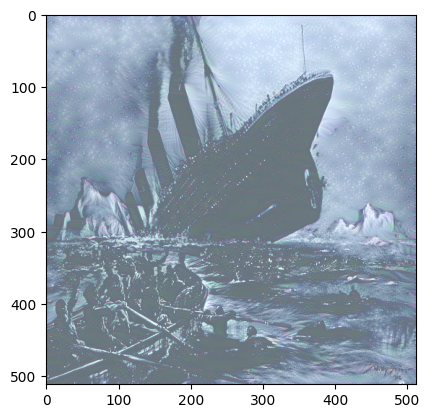

In [ ]:
def deprocess_image(processed_image):
    x = processed_image.copy()
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x = x[:, :, ::-1]
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = np.clip(x, 0, 255).astype('uint8')
    return x

content_image = load_and_process_image("titanic.jpg")
style_image = load_and_process_image("AI_art.jpg")

result = run_style_transfer(content_image, style_image)
final_image = deprocess_image(result.numpy())
plt.imshow(final_image)
plt.show()


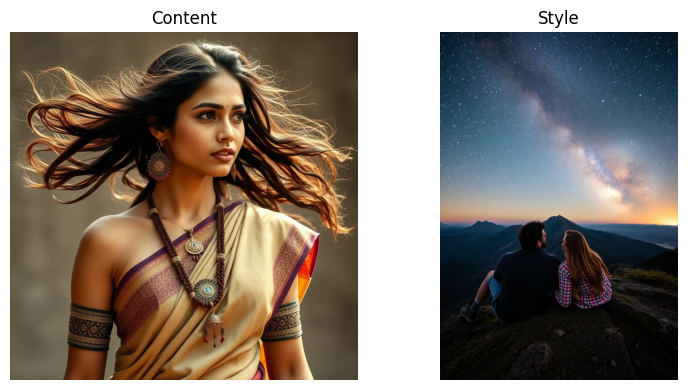

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load images
image1 = mpimg.imread('indian_girl.jpg')  # Content Image
image2 = mpimg.imread('AI_art.jpg')  # Style Image

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# first image
ax[0].imshow(image1)
ax[0].axis('off')
ax[0].set_title("Content")

# second image
ax[1].imshow(image2)
ax[1].axis('off')
ax[1].set_title("Style")

plt.tight_layout()
plt.show()

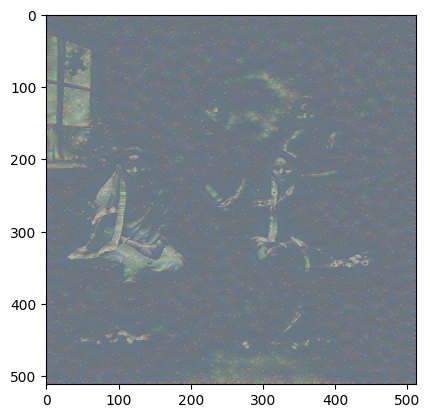

In [ ]:
image1 = load_and_process_image("vintage.jpg")
image2 = load_and_process_image("AI_art.jpg")
result = run_style_transfer(image1, image2)
final_image = deprocess_image(result.numpy())
plt.imshow(final_image)
plt.show()